### MNISTをCNNで分類しています。

early stopiingも実装しています。

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mlflow
from torchvision import transforms,datasets

In [2]:
config={
    'batch_size':100,
    'epochs':100
}

In [3]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=True, path='checkpoint/MNIST_CNN_checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.__early_stop = False
        self.val_acc_max = -np.Inf
        self.path = path
        
        
    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        return self.__early_stop
        
        
    def update(self, val_acc, model):
        """Call after one epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        if self.best_acc is None:
            self.best_acc = val_acc
            self.save_checkpoint(model, val_acc)
        elif val_acc < self.best_acc:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.__early_stop = True
        else:
            self.best_acc = val_acc
            self.save_checkpoint(model, val_acc)
            self.counter = 0

            
    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc
        
        
        
    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        if self.verbose:
            print(f'Loading model from last checkpoint with validation accuracy {self.val_acc_max:.6f}')
        model.load_state_dict(torch.load(self.path))
        return model

early_stopping=EarlyStopper(patience=7)

In [4]:
transform = transforms.Compose([transforms.RandomRotation(degrees=(-180, 180)),transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()])

dataloader_train=torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist',train=True,download=True,transform=transform),
    batch_size=config['batch_size'],
    shuffle=True
)

dataloader_valid=torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist/',train=False,download=True,transform=transform),
    batch_size=config['batch_size'],
    shuffle=True
)

In [5]:
class Dropout(nn.Module):
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        super().__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x):
        # 学習時はdropout_ratio分だけ出力をシャットアウト
        if self.training:
            self.mask = torch.rand(*x.size()) > self.dropout_ratio
            return x * self.mask.to(x.device)
        # 推論時は出力に`1.0 - self.dropout_ratio`を乗算することで学習時の出力の大きさに合わせる
        else:
            return x * (1.0 - self.dropout_ratio)

In [6]:
class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # Heの初期化
        # in_dim: 入力の次元数，out_dim: 出力の次元
        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))

        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)

In [7]:
conv_net = nn.Sequential(
    nn.Conv2d(1, 16, 3),              # 28*28*1 -> 26*26*16
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 26x26x16 -> 13x13x16
    nn.Conv2d(16, 32,3),             # 13x13x16 -> 11x11x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 11x11x32 -> 5x5x32
    nn.Conv2d(32, 64, 3),            # 5x5x32 -> 2x2x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 2x2x64 -> 1x1x64
    nn.Flatten(),
    nn.Linear(1*1*64, 128),
    Dropout(0.5),
    nn.ReLU(),
    nn.Linear(128, 10)
)


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net.apply(init_weights)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

model=conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

Validation accuracy increased (-inf --> 0.148900).  Saving model ...
EPOCH: 1, Train [Loss: 0.699, Accuracy: 0.770], Valid [Loss: 0.331, Accuracy: 0.893]
Validation accuracy increased (0.148900 --> 0.150783).  Saving model ...
EPOCH: 2, Train [Loss: 0.366, Accuracy: 0.888], Valid [Loss: 0.294, Accuracy: 0.905]
Validation accuracy increased (0.150783 --> 0.154633).  Saving model ...
EPOCH: 3, Train [Loss: 0.311, Accuracy: 0.906], Valid [Loss: 0.228, Accuracy: 0.928]
EarlyStopping counter: 1 out of 7
EPOCH: 4, Train [Loss: 0.284, Accuracy: 0.915], Valid [Loss: 0.272, Accuracy: 0.916]
Validation accuracy increased (0.154633 --> 0.156717).  Saving model ...
EPOCH: 5, Train [Loss: 0.267, Accuracy: 0.921], Valid [Loss: 0.186, Accuracy: 0.940]
Validation accuracy increased (0.156717 --> 0.156933).  Saving model ...
EPOCH: 6, Train [Loss: 0.253, Accuracy: 0.924], Valid [Loss: 0.191, Accuracy: 0.942]
EarlyStopping counter: 1 out of 7
EPOCH: 7, Train [Loss: 0.245, Accuracy: 0.927], Valid [Loss: 

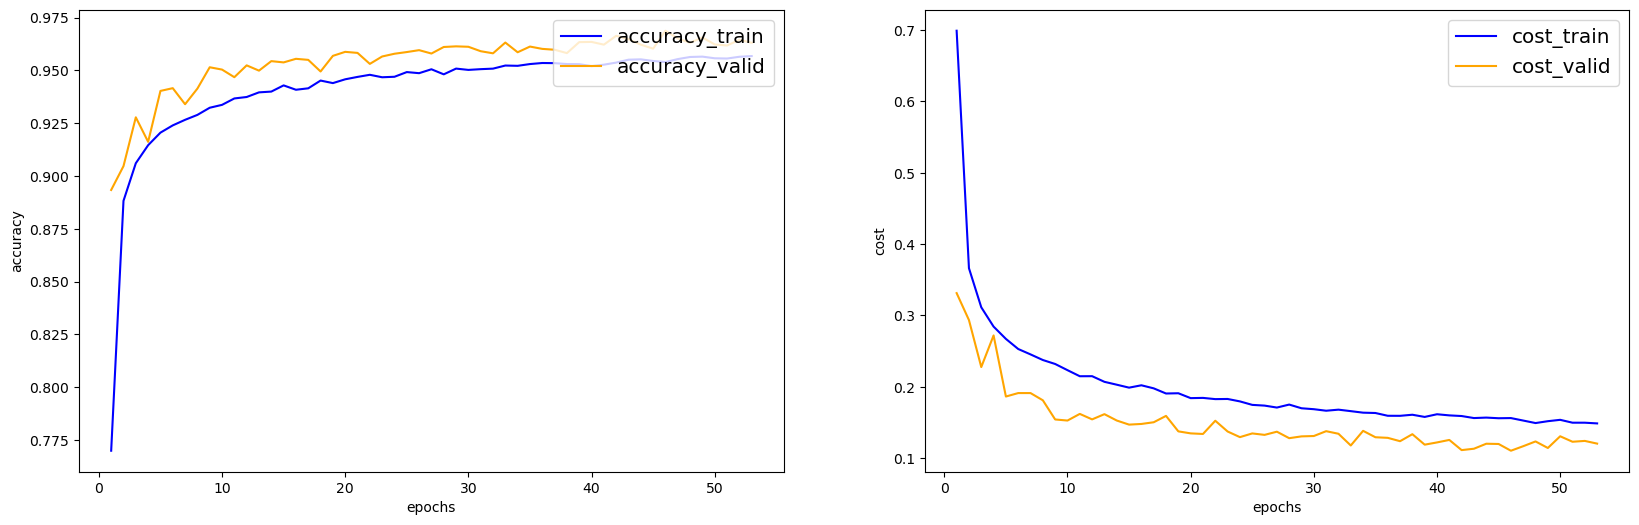

In [8]:

accuracy_train=[]
accuracy_valid=[]
cost_train=[]
cost_valid=[]#このリストをforの中にいれてしまうと新しいリストが毎回作られてしまう。必ず外に出すこと

for epoch in range(config['epochs']):
    losses_train = []  # 訓練誤差を格納しておくリスト
    losses_valid = []  # 検証データの誤差を格納しておくリスト

    conv_net.train()  # 訓練モードにする
    n_train = 0  # 訓練データ数
    acc_train = 0  # 訓練データに対する精度
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    accuracy_train.append(acc_train/n_train)
    cost_train.append(np.mean(losses_train))

    conv_net.eval()  # 評価モードにする
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    accuracy_valid.append(acc_val/n_val)
    cost_valid.append(np.mean(losses_valid))

    early_stopping.update(acc_val/n_train, model)

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))
    
    if early_stopping.early_stop:
        print('Early stopping !')
        break

model = early_stopping.load_checkpoint(model)

y=len(accuracy_train)

x=np.arange(1,y+1,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right',fontsize='x-large') 
ax2.legend(loc = 'upper right',fontsize='x-large') 

plt.savefig('image/CNN_MNIST_DropOut2.png')
plt.show()
torch.save(model.state_dict(), "model/CNN_MNIST.pth")


In [9]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor() )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pprint

correct = 0
total = 0
prediction=[]
label_list=[]
# 勾配を記憶せず（学習せずに）に計算を行う
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        prediction.extend(predicted.tolist())
        label_list.extend(labels.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

metrix=confusion_matrix(prediction,label_list)
print(classification_report(prediction,label_list))
cmp = ConfusionMatrixDisplay(metrix)


cmp.plot(cmap=plt.cm.Blues)

100%|██████████| 170498071/170498071 [00:19<00:00, 8538616.26it/s] 


Extracting data/cifar-10-python.tar.gz to data


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[4, 3, 32, 32] to have 1 channels, but got 3 channels instead